# PCA & K-Means Cluster Analysis of Personal IMDB Ratings
### Objectives:
1. Attempting to Find patterns in <b>My IMDb movie Ratings </b>over a period of 5 Years.<b> Find insights about preferences etc., Important Features </b>Using (I) EDA (II) K-Means Clustering.
2. Find <b>Interesting Clusters of Movies Using K-Means Clustering</b>.
3. Use <b>Principal Component Analysis </b>to improve Clustering output.
4. Gathering Insights on preferences by performing <b>hypothesis testing on these clusters</b> with respect to mean Ratings..

### Insights :
<p> <b>Statisticaly Significant Clusters </b>indicate that the author:<br>
    1. Prefers - Prestige Dramas, Moderately popular/Successful Romantic/Comedic Dramas.<br>
    2. Dislikes - Newer Action-Adventure, Sci-Fi , Superhero movies, Newer Hindi Movies.
It was also found that the IMDb rating, Popularity of movies were important positive features, whereas the year of release of a movie had an inverse relationship on the rating on the movie.<br>
<b>Clusters are also formed of films by directors that the author</b> seems to prefer (high mean difference to the overall mean of ratings), These include films by Directors Satyajit Ray, Brad bird, Andrew Stanton, Dean DeBlois, Edgar Wright, Steven Spielberg, Wes Anderson etc.<br>
<b>Clusters of Directors that make longer than average movies</b> were also formed but were not found to have a relevant effect on the preference of the author. The clusters with the most positive deviation in popularity were of films by David Fincher, Christopher Nolan.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
import warnings

pd.set_option('display.max_rows', 1000)
warnings.filterwarnings('ignore')

In [2]:
path = str(Path.cwd()) + '/Data/imdb_ratings_april_2020.csv'

data = pd.read_csv(path, engine='python', index_col=0)

In [3]:
# Filter Dataframe

film_filt = (data['Title Type'] == 'movie')
data_film = data.loc[(film_filt)]

# Extra data from OMDB
data_suppl = pd.read_csv('Data/wrangled_Film_data_from_OMDB_API.csv', engine='python', index_col=0)
data_film = pd.concat([data_film, data_suppl], axis = 1)

# Keeping Backup Dataframe
data_film_orig = data_film

## 1. Exploratory Analysis & Visualizations

### Univariate 

#### BoxPlots for Quantitative Vars.
Insights:
1. Most of the Ratings lie between the rating 7 and 8, this is slightly lower compared to the IMDb users, But this could be misleading as Discrete vs Continuous Comaprison.
2. The author generally likes watching Longer Movies.
3. Although most movies watched are newer, their is a long tail towards older movies, author doesn't mind the occassional older movies.
4. Majority of the movies watched are on the lower end of Popularity. 

In [4]:
def plot_box_num_uni(df):
    """ Plots Boxplots for all Numerical Columns in Dataframe.
    """
    fig = plt.figure()
    fig.set_figheight(30)
    fig.set_figwidth(20)
    for i, item in enumerate(df.select_dtypes([np.number]).columns.to_list()):
        ax = fig.add_subplot(len(df.select_dtypes([np.number]).columns.to_list()), 3, i+1)
        sns.boxplot(x = str(item), data = df)
        ax.set_title(item)

    fig.show()

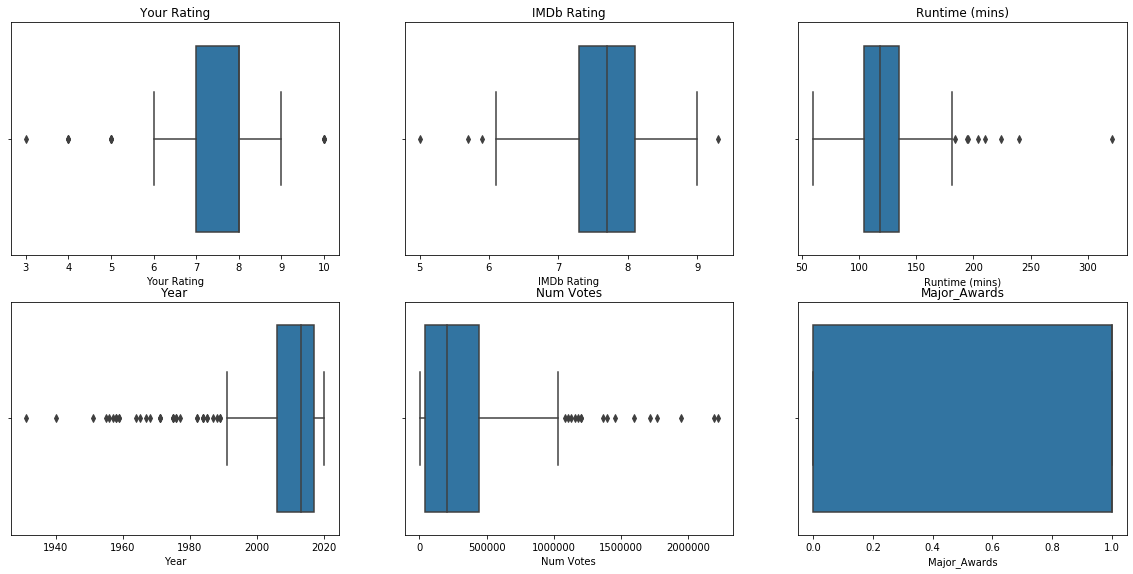

In [5]:
plot_box_num_uni(data_film)

#### Division of Ratings accross Genres

In [6]:
data_film[['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6','Genre7']] = data_film.Genres.str.split(',', expand=True)
data_film.drop(['Genre2','Genre3', 'Genre4','Genre5','Genre6','Genre7'], axis= 1, inplace = True)
# Loss of info by dropping secondary, tertiary genres but will result in duplication, is complex.

In [7]:
# Loss of info, Lee ukreich, ethan and joel coen etc are big loosers. Complex fix later.
data_film[['Director1','Director2','Director3', 'Director4']] = data_film.Directors.str.split(',', expand=True)
data_film.drop(['Director2','Director3', 'Director4'], axis = 1, inplace = True)

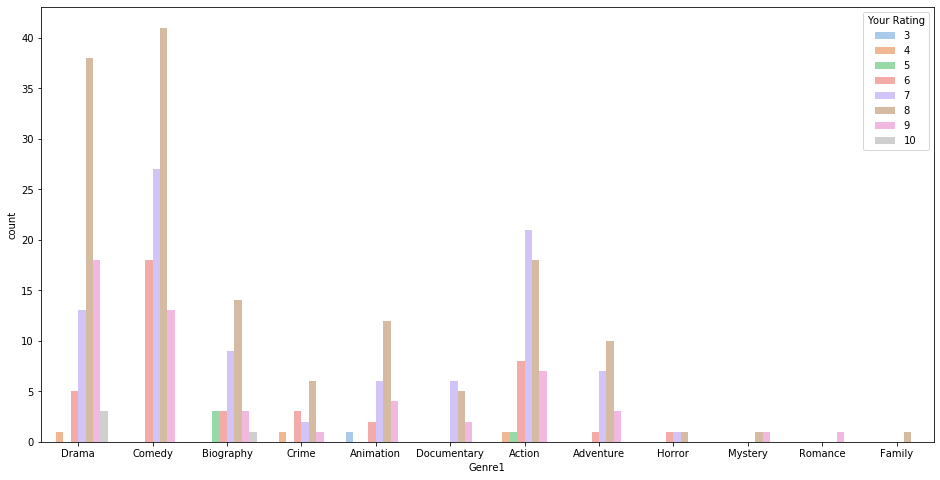

In [8]:
plt.figure(figsize=(16,8))
ax = sns.countplot(x = 'Genre1', data = data_film, hue="Your Rating", palette="pastel")
ax.legend(loc='upper right', title = 'Your Rating')
plt.show()

#### Most Watched Directors

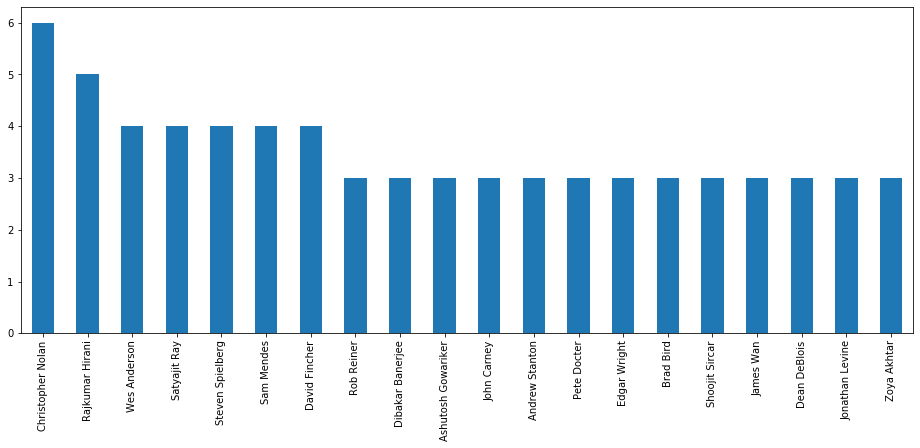

In [9]:
plt.figure(figsize = (16,6))
data_film.Director1.value_counts()[:20].plot(kind = 'bar')
plt.show()

## Bivariate Analysis With Respect to 'Your Rating'
1. I generally follow the same trends as the IMDb ratings. The movies I've rated the highest tend to be highly rated movies in general. There is a large percentage of movies I've rated lower that the IMDb public likes.
2. The lowest rated movies tend to have longer run times compared to the average movies. The highest rated movies tend to be longer too.
3. Most higher rated movies are more spread out when it comes to year of release. The violin plot shows this better.
4. There is high spread in the popularity of the movies rated higher. Will check relationship using Linear Regression later.

In [10]:
def plot_box_num_biv(df, categ):
    """ Plots Boxplots for all Numerical Columns in Dataframe with respect to a target column.
    """
    fig = plt.figure()
    fig.set_figheight(30)
    fig.set_figwidth(20)
    for i, item in enumerate(df.select_dtypes([np.number]).columns.to_list()):
        ax = fig.add_subplot(len(df.select_dtypes([np.number]).columns.to_list()), 2, i+1)
        sns.boxplot(x = categ, y = str(item), data = df)
        ax.set_title(item)

    fig.show()

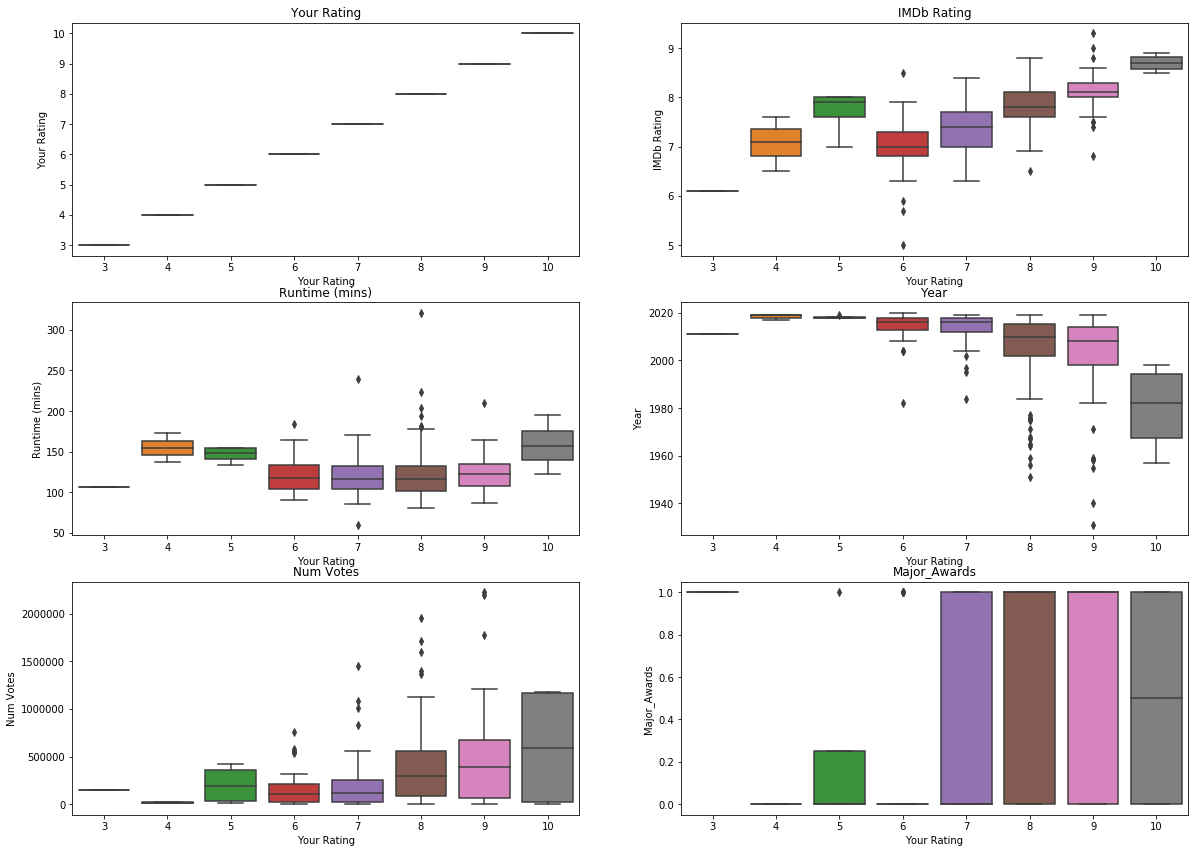

In [11]:
plot_box_num_biv(data_film, 'Your Rating')

## Checking Relationships Between Data

### Checking Pearsons Correlation 

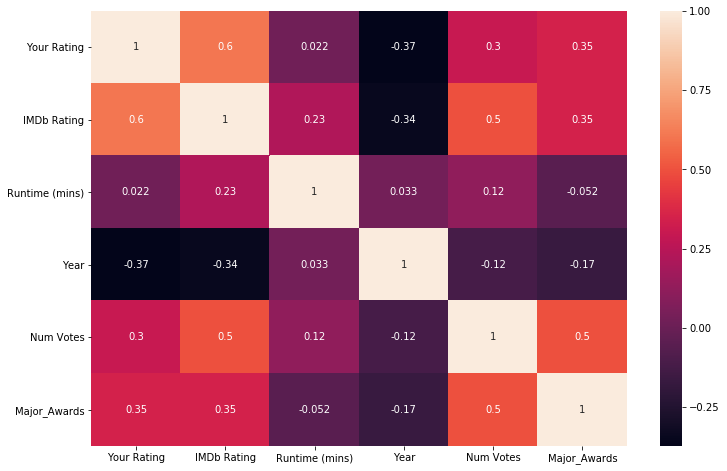

In [12]:
plt.figure(figsize=(12,8))
sns.heatmap(data = data_film.corr(), annot=True)
plt.show()

## Linear Regression Plots to check If there is a Linear Relationships between Your Rating and Other Quantitaive Vars., Comparison with IMDb Users.
0. A strong relationship is not expected between Your Ratings (sample) and IMDb Ratings (population), this is backed up by the first plot. It was observed that the std deviation for Your rating is greater, which is to be expected from a sample of size 1. But this is not of interest as we want to know which features contribute most to the Ratings and whether there is significant difference between the author and the IMDB Population.
1. There is a Strong Positive Linear Relationship between IMDb user Ratings and My Ratings, not significantly different ratings, makes sense as movies rated higher by the population would be good movies in geneal. There are quite a few outliers visible. More interested in these values as they could show possible pecularities in taste and important features.
2. No Significant Relationship linear relationship between runtime and Your rating. There are high leverage points. Weaker relationship compared to Imdb Users.
3. Appears to be weak negative relationship between Year of release and Your Rating, stronger than other IMDb users , author favors older movies but could be possible that only good older movies watched. (Check Leverage Statistics to see if this is a problem.)
4. Appears to be a weak positive relationship between popularity (Num of votes) and Your rating. Some high leverage points. Comparing with Rating by IMDb users, this relationship appears to be extremely similar but larger confidence interval. So yeah, popular movies tend to be rated higher, again could just be a correlation.

In [13]:
def plot_lin_num_biv(df):
    """ Plots Linear Regression best fit lines for all Numerical Columns in Dataframe with respect your rating column.
    """
    fig = plt.figure()
    fig.set_figheight(30)
    fig.set_figwidth(20)
    for i, item in enumerate(df.select_dtypes([np.number]).columns.to_list()):
        ax = fig.add_subplot((len(df.select_dtypes([np.number]).columns.to_list())), 2, i+1)
        sns.regplot(y = 'Your Rating', x = str(item), data = data_film, label = 'Your Ratings')
        sns.regplot(y = 'IMDb Rating', x = str(item), data = data_film, label = 'IMDb Ratings')
        ax.legend()
        ax.set_ylabel('Rating')
        ax.set_title('IMDb Rating, Your Rating - ' + item)
    fig.savefig('Graphs/Linear_rel.jpg')
    fig.show()

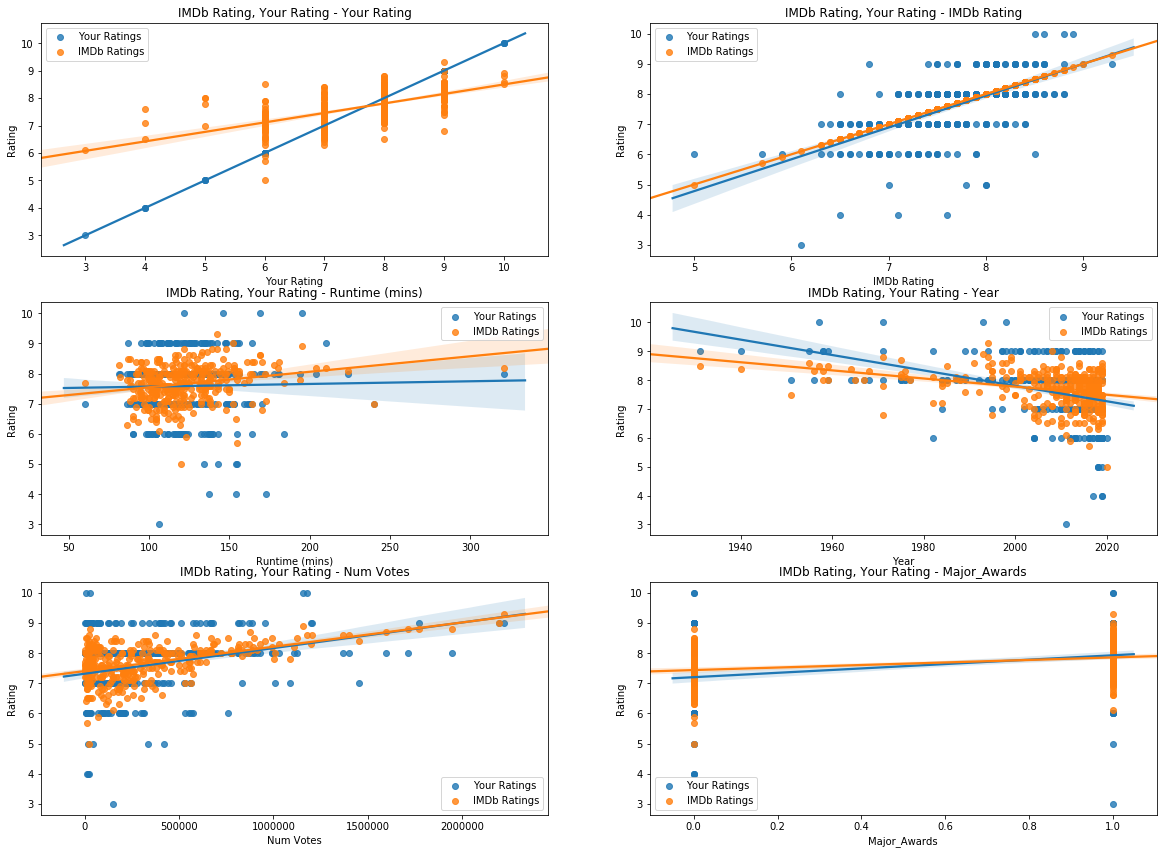

In [14]:
plot_lin_num_biv(data_film)

# 2. PCA and K-Means Clustering

### Feature Engineering, Dropping Useless columns, One-hot Encodding Categorical Column like Genre, Director etc.

In [15]:
data_film.drop(['Genres', 'Directors'], axis = 1, inplace = True)

#### Lets see if we can Eye-ball clusters.

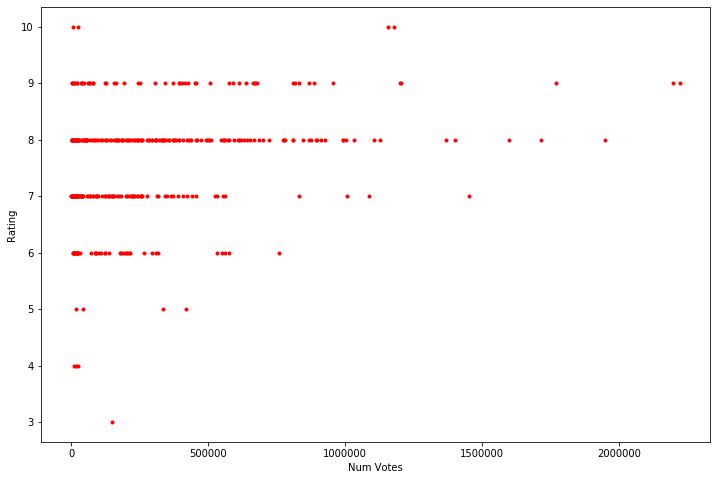

In [19]:
plt.figure(figsize=(12,8))
plt.plot( data_film['Num Votes'], data_film['Your Rating'].to_list(), 'r.')
plt.xlabel('Num Votes')
plt.ylabel('Rating')
plt.show()

#### Feature Engineering - One - Hot encode Genre, Directors and Dropping a few Columns, Convert Rated to Numerical

In [20]:
data_film = pd.get_dummies(data_film, prefix='Genre', columns=['Genre1'])
data_film = pd.get_dummies(data_film, prefix='Director', columns=['Director1'])
data_film[['Rated_Year', 'Rated_month', 'Rated_Day']] = data_film['Date Rated'].str.split('-', expand = True)
data_film.drop(['Rated_month', 'Rated_Day'], axis = 1, inplace = True)
data_film.drop('Date Rated', axis = 1, inplace = True)
data_film[['Release_Year', 'Release_month', 'Release_Day']] = data_film['Release Date'].str.split('-', expand = True)
data_film.drop(['Release_month', 'Release_Day'], axis = 1, inplace = True)
data_film.drop('Release Date', axis = 1, inplace = True)
data_film.drop(['Title Type', 'URL'], axis = 1, inplace = True)

In [21]:
data_film = pd.get_dummies(data_film, prefix='Censor_rating', columns=['Rated'])
data_film = pd.get_dummies(data_film, prefix='Major_awards', columns=['Major_Awards'])
data_film = pd.get_dummies(data_film, prefix='Metascore_binned', columns=['Metascore_binned'])
data_film = pd.get_dummies(data_film, prefix='Box_office_binned', columns=['Box_office_binned'])
data_film = pd.get_dummies(data_film, prefix='Country', columns=['Country'])
data_film = pd.get_dummies(data_film, prefix='Language', columns=['Language'])

#### Making Copy as we'll drop Title and convert to numeric

In [22]:
data_film_num = data_film
data_film_num.drop(['Title'], axis = 1, inplace=True)
data_film_num.drop(['Release_Year'], axis = 1, inplace=True)
data_film_num['Rated_Year'] = data_film_num['Rated_Year'].astype(int)

#### Visualizing New Info

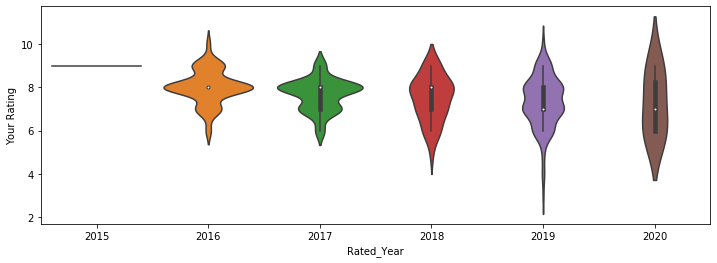

In [23]:
plt.figure(figsize=(12,4))
sns.violinplot(x = 'Rated_Year', y = 'Your Rating', data =data_film_num )

# Curse of Dimensionality - 304 Features for 345 samples. 

# Principal Components Analysis to Reduce Dimensionality of Data

#### Standardize Data

In [25]:
from sklearn.preprocessing import StandardScaler
data_film_scaled = StandardScaler().fit_transform(data_film_num.values)

#### Restoring Indexes And Column Names

In [26]:
data_film_scaled_df = pd.DataFrame(data = data_film_scaled, index = data_film_num.index, columns = data_film_num.columns)

#### Lets Target that 50% Percent of the Variance is explained by the principal components - Explained by 107 Features.

In [27]:
from sklearn.decomposition import PCA

target_variance = 0.50

for i in range(len(data_film_scaled_df.columns)):
    pca_film = PCA(n_components=i)
    pca_components_film = pca_film.fit_transform(data_film_scaled_df)
    #print(f'Total Explained Variance is {np.sum(pca_film.explained_variance_ratio_)}')
    if np.sum(pca_film.explained_variance_ratio_) > target_variance:
        #print(f'No of Components that explain 50% of Variance: {i}')
        break

print(f'No of Components that explain 50% of Variance: {i}')

No of Components that explain 50% of Variance: 107


### Checking important Features for First Principal Component
No single features dominates, which is good.

In [28]:
first_comp = pca_film.components_[0]
# Creating Dataframe for correspoding Columns in original Dataframe
first_comps = pd.DataFrame(zip(first_comp, data_film_scaled_df.columns), columns = ['Weights', 'Features'])
first_comps['abs_weights']=first_comps['Weights'].apply(lambda x: np.abs(x))
first_comps.sort_values('abs_weights', ascending=False)[:10]

,Weights,Features,abs_weights
291,0.340098,Country_India,0.340098
274,0.322547,Censor_rating_Not Rated,0.322547
278,-0.306267,Major_awards_1,0.306267
277,0.306267,Major_awards_0,0.306267
279,-0.287301,Metascore_binned_high,0.287301
302,0.272816,Language_Hindi,0.272816
300,-0.245289,Country_USA,0.245289
4,-0.243208,Num Votes,0.243208
301,-0.167595,Language_English,0.167595
275,-0.156709,Censor_rating_R,0.156709


In [29]:
list_pca_film = list(pca_components_film)

## Visualizing the High Dimensional data and Principal Components using T-SNE
Some clusters are visible by eye in the tsne output of the pricipal components, lets see if the Clustering algorithm picks this up.

In [30]:
from sklearn.manifold import TSNE

In [31]:
embed_scale = TSNE(n_components=2).fit_transform(data_film_scaled_df)
embed_pc = TSNE(n_components=2).fit_transform(pca_components_film)

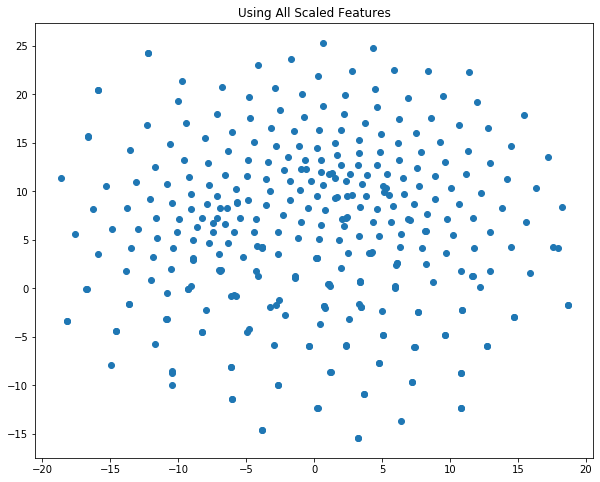

In [32]:
plt.figure(figsize=(10,8))
plt.title('Using All Scaled Features')
plt.scatter(embed_scale[:,:1],embed_scale[:,1:])

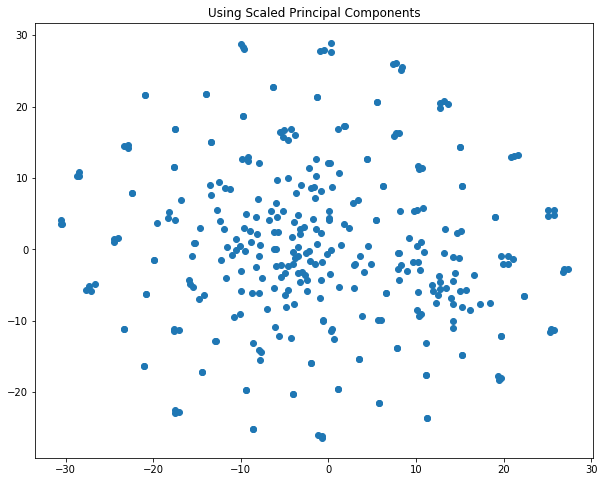

In [33]:
plt.figure(figsize=(10,8))
plt.title('Using Scaled Principal Components')
plt.scatter(embed_pc[:,:1],embed_pc[:,1:])

# Fitting Kmeans - Clustering Using Principal Components

### Finding Optimal Number of Clusters - Using Elbow Method and SSE Score, Silhouette score Analysis.
1. An Elbow somewhat appears around 90 clusters.
2. Average silhoutte score is lowest around the same region before slowly increasing.(Aournd 0.35).

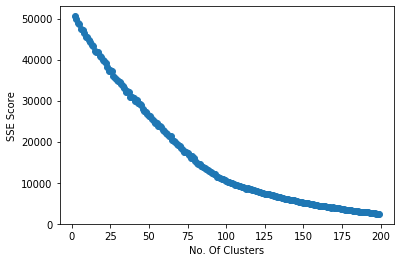

In [114]:
# calculate distortion for a range of number of cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

distortions = []
sil_score = []
for i in range(2,200):
    cluster_film = KMeans(n_clusters = i, n_init=10, max_iter= 100).fit(list_pca_film)
    distortions.append(cluster_film.inertia_)
    sil_score.append(silhouette_score(list_pca_film, cluster_film.labels_, metric='euclidean'))
    
plt.xlabel('No. Of Clusters')
plt.ylabel('SSE Score')
plt.plot(range(2, 200), distortions, marker='o')
plt.savefig('Graphs/Clusters_SSE_plot.jpg')

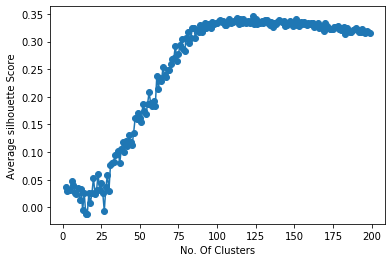

In [115]:
plt.xlabel('No. Of Clusters')
plt.ylabel('Average silhouette Score')
plt.plot(range(2, 200), sil_score, marker='o')

In [77]:
cluster_film = KMeans(n_clusters = 90, n_init=10, max_iter= 100).fit(list_pca_film)
pred_film = cluster_film.labels_

In [251]:
# Using code from sklearn silhoutte analyis example.

from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(list_pca_film, pred_film )

y_lower = 10
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 72)

silhouette_avg = sil_score[90]
for i in range(1,90):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[pred_film == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / i)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.savefig('Graphs/Cluster_silhoutte_analysis.jpg')
plt.show()

'\nfrom sklearn.metrics import silhouette_samples\nimport matplotlib.cm as cm\n\n# Compute the silhouette scores for each sample\nsample_silhouette_values = silhouette_samples(list_pca_film, pred_film )\n\ny_lower = 10\nfig, ax1 = plt.subplots(1, 1)\nfig.set_size_inches(18, 72)\n\nsilhouette_avg = sil_score[90]\nfor i in range(1,90):\n    # Aggregate the silhouette scores for samples belonging to\n    # cluster i, and sort them\n    ith_cluster_silhouette_values =         sample_silhouette_values[pred_film == i]\n\n    ith_cluster_silhouette_values.sort()\n\n    size_cluster_i = ith_cluster_silhouette_values.shape[0]\n    y_upper = y_lower + size_cluster_i\n\n    color = cm.nipy_spectral(float(i) / i)\n    ax1.fill_betweenx(np.arange(y_lower, y_upper),\n                      0, ith_cluster_silhouette_values,\n                      facecolor=color, edgecolor=color, alpha=0.7)\n\n    # Label the silhouette plots with their cluster numbers at the middle\n    ax1.text(-0.05, y_lower + 0.5 

### Lets Place the cluster labels back into dataframe and check which Movies got Clustered Together.

In [119]:
data_film_orig = data.loc[(film_filt)]
data_film_orig = pd.concat([data_film_orig, data_suppl], axis = 1)
data_film_orig['Cluster'] = pred_film
# saving clusters.
data_film_orig.to_csv('Data/Clusters_from_k_means_pca.csv')

# Visualizing and Analyzing the Clusters
1. Mostly Small Clusters are being formed, some larger clusters can be seen too. The larger clusters have plenty of overlap.
2. Investigating individual clusters and their silhoutte scores, most large clusters have lower than average silhoutte scores and the clusters with a reasonable size and above average silhoutte score are clusters of films by a particular director.

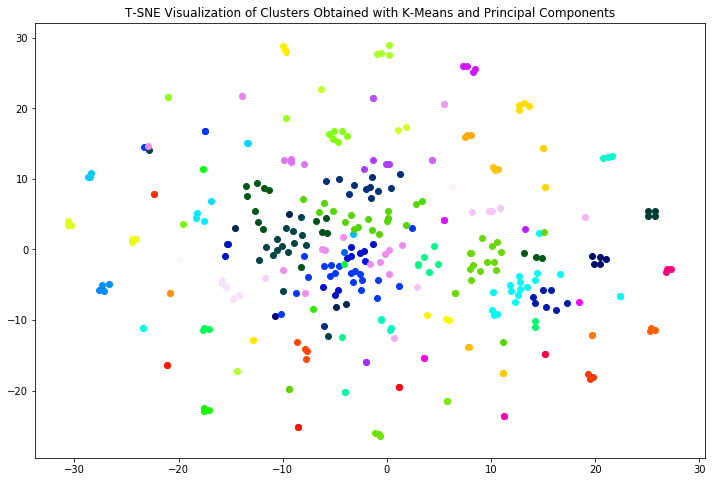

In [121]:
grouped_df = data_film_orig.groupby(['Cluster'])
embed_df = pd.DataFrame({'ax1': embed_scale[:,:1].ravel(), 'ax2': embed_scale[:,1:].ravel(), 'clusters': pred_film})
embed_pc_df = pd.DataFrame({'ax1': embed_pc[:,:1].ravel(), 'ax2': embed_pc[:,1:].ravel(), 'clusters': pred_film})
grouped_df_pc = embed_pc_df.groupby('clusters')
plt.figure(figsize = (12,8))
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_ncar(np.linspace(0, 1, 90))))
for i in range(90):
    plt.scatter(grouped_df_pc.get_group(i).ax1.tolist(), grouped_df_pc.get_group(i).ax2.tolist(), label = i)
plt.title('T-SNE Visualization of Clusters Obtained with K-Means and Principal Components')
plt.savefig('Graphs/Cluster_formed.jpg')
plt.show()

### Investigating Clusters

### Cluster Statistics - 
1. Checking Difference in Mean of Your Rating and IMDb Rating for clusters.
2. Mean difference in Runtime(Length).
3. Median Num Votes(Popularity) as data is Highly Skewed.
4. Median Year of Release.

In [122]:
data_film_cluster_stats = data_film_orig.groupby(['Cluster'])['Your Rating'].count()
data_film_cluster_stats = data_film_cluster_stats.to_frame('Count')
data_film_cluster_stats['your_imdb_Rating_Mean_Difference'] = data_film_orig.groupby(['Cluster'])['Your Rating'].mean() - data_film_orig.groupby(['Cluster'])['IMDb Rating'].mean()
data_film_cluster_stats['RunTime_Mean_Difference'] = data_film_orig.groupby(['Cluster'])['Runtime (mins)'].mean() - data_film_orig['Runtime (mins)'].mean()
data_film_cluster_stats['votes_Median_Difference'] = data_film_orig.groupby(['Cluster'])['Num Votes'].median() - data_film_orig['Num Votes'].median()
data_film_cluster_stats['Year_Median_diff'] = data_film_orig.groupby(['Cluster'])['Year'].median() - data_film_orig['Year'].median()
data_film_cluster_stats.sort_values('Count', ascending=False, inplace=True)

#### 1 Sample T-Test to compare population your rating and cluster your rating.

In [123]:
# Lets perform 1 sample two-tailed t test between population your rating (data_film) and sample clust_0
from scipy.stats import ttest_1samp

def ttest_1samp_cluster_pop(cluster_number):
    """ Testing to see if there is a significant difference between ratings given to films in cluster and 
    the population (Ratings given to all films).
    Null (h0) - There is no difference. (So, No preference to this cluster.)
    Alternate (h1) - There is a difference, these are rated higher/lower by the user.
    """
    pop_film = data_film['Your Rating'].tolist()
    print(f'Population Mean {np.mean(pop_film)}, degrees of freedom {len(pop_film)}')

    clust_3_sample = grouped_df.get_group(cluster_number)['Your Rating'].tolist()
    print(f'Sample mean {np.mean(clust_3_sample)}, degrees of freedom {len(clust_3_sample)}')

    tstat, pvalue = ttest_1samp(clust_3_sample, np.mean(pop_film))
    print('\nT-Stat for hypothesis test {} and P-value {}'.format(tstat, pvalue))
    print('T-critical for n = {}, alpha = 0.05 , look up in table'.format(len(clust_3_sample)-1))
    if pvalue<0.05:
        print('Statistically significant result, Reject the NUll - \nThere is siginificant difference between ratings given to films in this group and the population.')
    else:
        print('Statistically insignificant result, Failled to reject the null.')

In [124]:
def get_genre_cluster(genre = 'Animation'):
    return data_film_orig.loc[data_film.Genres.str.split(',', expand=True)[0] == genre].sort_values('Cluster')

### 1. Clusters of Interest on the basis of Mean Difference in Rating between Your Rating and IMDb Ratings

In [125]:
# Only Keeping clusters with atleast 3 movies
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('Count').tail(10)

,Count,your_imdb_Rating_Mean_Difference,RunTime_Mean_Difference,votes_Median_Difference,Year_Median_diff
Cluster,,,,,
4,7,-0.528571,-16.371014,0.0,2.0
5,9,-0.866667,0.073430,232993.0,3.0
9,12,0.350000,-0.787681,76734.0,-1.0
81,12,-0.008333,-15.954348,-117709.0,5.0
7,13,-0.184615,7.705909,134184.0,2.0
6,16,-0.087500,-17.371014,-10659.5,-1.5
34,16,-0.637500,15.441486,-188993.0,3.0
32,17,-0.117647,3.746633,301776.0,3.0
19,18,-0.816667,6.740097,-185185.5,4.5


In [126]:
cluster_stat_large.sort_values('your_imdb_Rating_Mean_Difference').head(5)

,Count,your_imdb_Rating_Mean_Difference,RunTime_Mean_Difference,votes_Median_Difference,Year_Median_diff
Cluster,,,,,
18,3,-1.266667,7.295652,131146.0,3.0
61,4,-1.150000,-22.371014,26811.5,-1.0
5,9,-0.866667,0.073430,232993.0,3.0
76,4,-0.825000,7.128986,87911.0,2.0
19,18,-0.816667,6.740097,-185185.5,4.5


In [127]:
cluster_stat_large.sort_values('your_imdb_Rating_Mean_Difference').tail(5)

,Count,your_imdb_Rating_Mean_Difference,RunTime_Mean_Difference,votes_Median_Difference,Year_Median_diff
Cluster,,,,,
22,4,0.525000,-26.371014,-34436.5,-2.5
13,4,0.525000,30.628986,764168.0,-13.0
29,3,0.533333,-21.037681,90756.0,1.0
85,5,0.540000,10.828986,-198826.0,3.0
55,3,0.666667,-14.371014,203581.0,-3.0


### 2. Clusters of Interest on the basis of Mean difference in Runtime(Length).

In [128]:
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('RunTime_Mean_Difference').head(5)

,Count,your_imdb_Rating_Mean_Difference,RunTime_Mean_Difference,votes_Median_Difference,Year_Median_diff
Cluster,,,,,
24,7,-0.242857,-30.799586,-186229.0,3.0
26,3,0.133333,-30.704348,-16223.0,-26.0
45,3,-0.133333,-28.037681,578074.0,-4.0
22,4,0.525000,-26.371014,-34436.5,-2.5
15,3,0.066667,-24.037681,709233.0,-5.0


In [129]:
cluster_stat_large.sort_values('RunTime_Mean_Difference').tail(5)

,Count,your_imdb_Rating_Mean_Difference,RunTime_Mean_Difference,votes_Median_Difference,Year_Median_diff
Cluster,,,,,
38,6,-0.533333,22.462319,1224601.5,-2.0
13,4,0.525000,30.628986,764168.0,-13.0
1,5,-0.700000,33.228986,-133071.0,-4.0
60,3,-0.033333,36.962319,-176247.0,2.0
49,3,0.333333,73.962319,-123867.0,-9.0


### 3. Clusters of Interest on the basis of Median Num Votes(Popularity)

In [130]:
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('votes_Median_Difference').head(5)

,Count,your_imdb_Rating_Mean_Difference,RunTime_Mean_Difference,votes_Median_Difference,Year_Median_diff
Cluster,,,,,
85,5,0.540000,10.828986,-198826.0,3.0
3,4,0.150000,-12.371014,-191972.5,-56.0
34,16,-0.637500,15.441486,-188993.0,3.0
62,3,0.466667,10.628986,-187085.0,-5.0
24,7,-0.242857,-30.799586,-186229.0,3.0


In [131]:
cluster_stat_large.sort_values('votes_Median_Difference').tail(5)

,Count,your_imdb_Rating_Mean_Difference,RunTime_Mean_Difference,votes_Median_Difference,Year_Median_diff
Cluster,,,,,
13,4,0.525000,30.628986,764168.0,-13.0
46,3,-0.566667,13.628986,790919.0,-19.0
51,4,-0.050000,11.378986,887431.0,-8.5
2,4,-0.300000,7.128986,1091699.5,-11.0
38,6,-0.533333,22.462319,1224601.5,-2.0


### 4. Clusters of Interest on the basis of Median Year of Release.

In [132]:
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('Year_Median_diff').head(5)

,Count,your_imdb_Rating_Mean_Difference,RunTime_Mean_Difference,votes_Median_Difference,Year_Median_diff
Cluster,,,,,
3,4,0.150000,-12.371014,-191972.5,-56.0
26,3,0.133333,-30.704348,-16223.0,-26.0
46,3,-0.566667,13.628986,790919.0,-19.0
13,4,0.525000,30.628986,764168.0,-13.0
21,3,0.333333,-3.704348,-16566.0,-13.0


In [133]:
grouped_df = data_film_orig.groupby(['Cluster'])

## Interpreting Largest Clusters

#### Cluster 11 - Cluster of Romantic Comedies, Romantic Dramas.
1. 21 Films.
2. Rated favourably compared to IMDb.
3. Slighly shorter than mean , reasonably popular, newish movies. Rated Teen or Restriced.
4. All Major awards contendors and reasonably succesful films.($ 10-100Million).
5. Rated higher than your rating mean, Statistically Significant (1 sample T-test) group compared to all Your Ratings. (Definite Preference)

In [144]:
#grouped_df.get_group(11).head(30)
#grouped_df.get_group(11).describe()
ttest_1samp_cluster_pop(11)

Population Mean 7.58840579710145, degrees of freedom 345
Sample mean 8.0, degrees of freedom 21

T-Stat for hypothesis test 2.9822833303752154 and P-value 0.007363578828277226
T-critical for n = 20, alpha = 0.05 , look up in table
Statistically significant result, Reject the NUll - 
There is siginificant difference between ratings given to films in this group and the population.


#### Cluster 19 - Cluster of Newer Hindi Comedy, Drama, Action Movies.
1. 18 Films.
2. Rated very unfavourably compared to IMDb.
3. Newer Movies.
4. Rated much lower than your rating mean, Statistically Significant (1 sample T-test) group compared to all Your Ratings. (Definite Dislike)

In [152]:
#grouped_df.get_group(19).head(30)
#grouped_df.get_group(19).describe()
ttest_1samp_cluster_pop(19)

Population Mean 7.58840579710145, degrees of freedom 345
Sample mean 6.5, degrees of freedom 18

T-Stat for hypothesis test -4.999971840087577 and P-value 0.00010958470697740056
T-critical for n = 17, alpha = 0.05 , look up in table
Statistically significant result, Reject the NUll - 
There is siginificant difference between ratings given to films in this group and the population.


#### Cluster 32 - Mostly Newer Action, Adventure, Superhero movies.
1. 17 Films.
2. Rated almost the same as compared to IMdb
3. Mostly Newer Movies, not awards contendors, high-mid critic ratings.
4. Mostly Teen rated movies.
5. Rated the same as mean your rating, Statistically Insignificant (1 sample T-test) group compared to all Your Ratings. (No preference either way)

In [230]:
#print(grouped_df.get_group(32).describe())
#grouped_df.get_group(32).head(30)
#ttest_1samp_cluster_pop(32)

#### Cluster 34 - Mostly Newer Hindi, Action, Drama, Biographical movies.
1. 16 Films.
2. Rated lowered compared to IMdb.
3. Rated much lower than your rating mean, Statistically Significant (1 sample T-test) group compared to all Your Ratings. (Definite Dislike)

In [170]:
#print(grouped_df.get_group(34).describe())
#grouped_df.get_group(34).head(30)
ttest_1samp_cluster_pop(34)

Population Mean 7.58840579710145, degrees of freedom 345
Sample mean 6.9375, degrees of freedom 16

T-Stat for hypothesis test -2.317194224706545 and P-value 0.03503907106145302
T-critical for n = 15, alpha = 0.05 , look up in table
Statistically significant result, Reject the NUll - 
There is siginificant difference between ratings given to films in this group and the population.


#### Cluster 6 - Mostly Romantic Comedies that weren't critically acclaimed.
1. 16 Films.
2. Rated about the same as IMDb.
3. Reasonably succesful and popular.
4. Rated much lower than your rating mean, Statistically Significant (1 sample T-test) group compared to all Your Ratings. (Dislike, but already low rated movies.)

In [175]:
#print(grouped_df.get_group(6).describe())
grouped_df.get_group(6).head(30)
ttest_1samp_cluster_pop(6)

Population Mean 7.58840579710145, degrees of freedom 345
Sample mean 6.75, degrees of freedom 16

T-Stat for hypothesis test -4.329508919383558 and P-value 0.0005954145795448534
T-critical for n = 15, alpha = 0.05 , look up in table
Statistically significant result, Reject the NUll - 
There is siginificant difference between ratings given to films in this group and the population.


#### Cluster 11 - acclaimed biographical dramas
1. Rated the same as IMDb
2. Statistically insiginificant.

#### Cluster 7 - Critically lauded, Dramedies. Mostly Rated R.
1. Rated the same as IMDb
2. Statistically insiginificant.

#### Cluster 9 - Critically acclaimed, Dramas. Almost all Rated R.
1. Rated higher than IMDb
2. Rated higher than your rating mean, Statistically Significant (1 sample T-test) group compared to all Your Ratings. (Definite Preference)

In [233]:
#print(grouped_df.get_group(9).describe())
grouped_df.get_group(9).head(30)
ttest_1samp_cluster_pop(9)

Population Mean 7.58840579710145, degrees of freedom 345
Sample mean 8.166666666666666, degrees of freedom 12

T-Stat for hypothesis test 5.146196863219417 and P-value 0.0003201320841974889
T-critical for n = 11, alpha = 0.05 , look up in table
Statistically significant result, Reject the NUll - 
There is siginificant difference between ratings given to films in this group and the population.


##  Interpreting Clusters with Skewed Satistics.

#### Cluster 55 - Edgar Wright Comedies.
1. 3 Films.
2. Rated Much Higher than IMDb users.
3. Statistically Insignificant Result.

#### Cluster 85 - Documentaries, mostly F1.
1. 5 Films.
2. Rated Much Higher than IMDb users.
3. Statistically Insignificant Result.

#### Cluster 22 - Films by Wes Anderson.
1. 4 Films.
2. Rated Much more Favourably.
3. Statistically Insignificant Result.

#### Cluster 13 -Films by  Steven Spielberg.
1. 3 Films.
2. Rated Much more favourably.
3. Statistically Insignificant Result.

#### Cluster 29 - Films by  Dean Deblois - How To train Your Dragon series.
1. 3 Films.
2. Rated Much more favourably.
3. Statistically Insignificant Result.

#### Cluster 38 - Christopher Nolan Films
1. 6 Films.
2. Rated less favourably than IMDb.
3. Statistically Insignificant Result.

#### Cluster 3 - Stayajit Ray Films
1. 4 Films.
2. Rated about the same as IMDB.
3. Almost statistically significant.

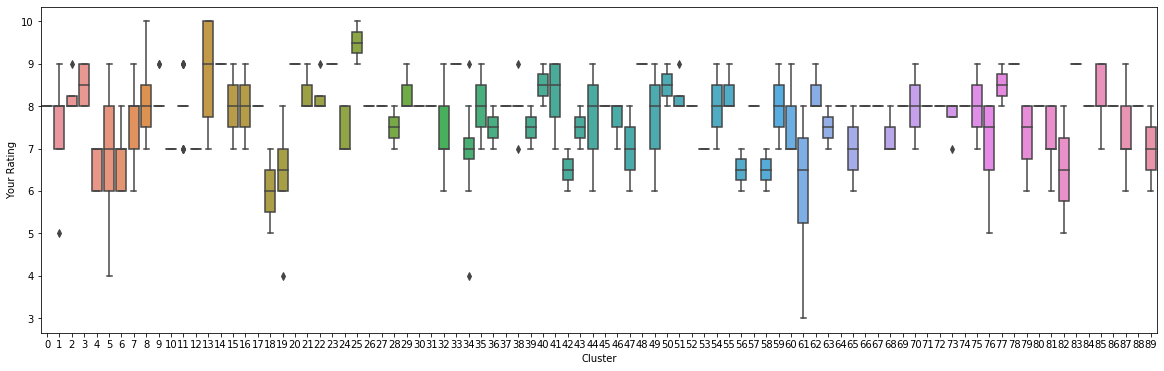

In [234]:
plt.figure(figsize=(20,6))
sns.boxplot(x = 'Cluster', y = 'Your Rating', data = data_film_orig)

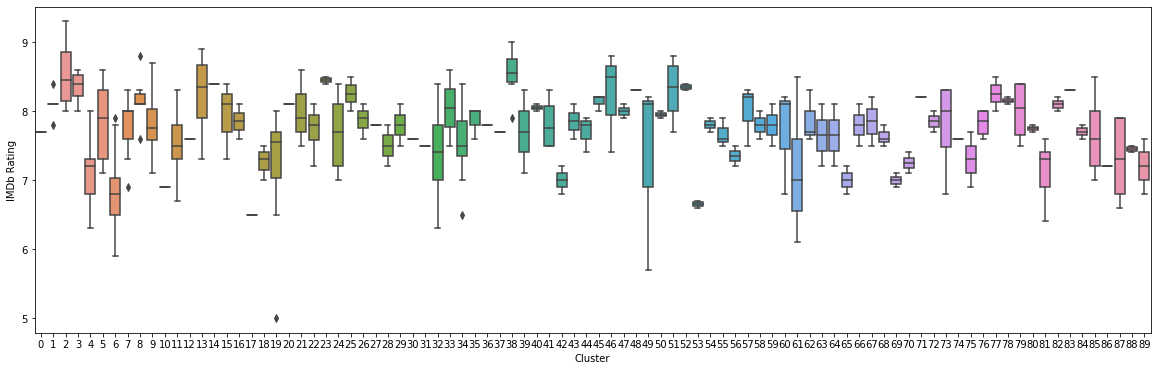

In [235]:
plt.figure(figsize=(20,6))
sns.boxplot(x = 'Cluster', y = 'IMDb Rating', data = data_film_orig)

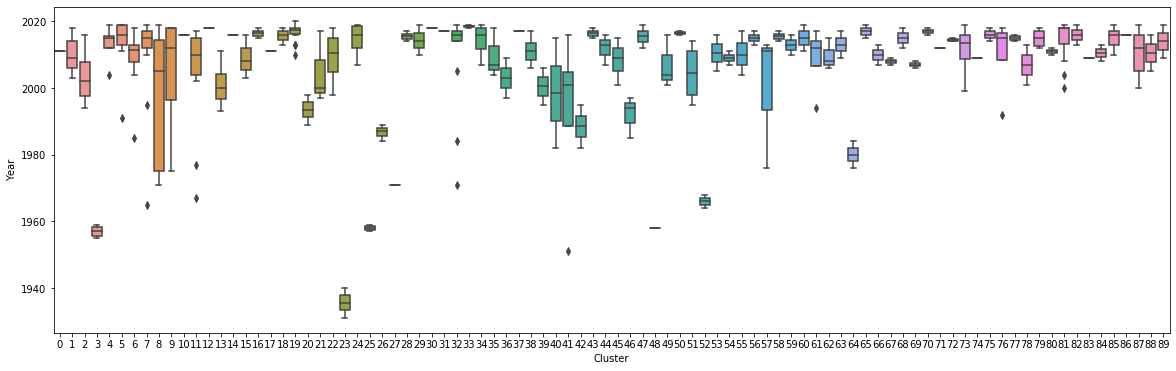

In [236]:
plt.figure(figsize=(20,6))
sns.boxplot(x = 'Cluster', y = 'Year', data = data_film_orig)

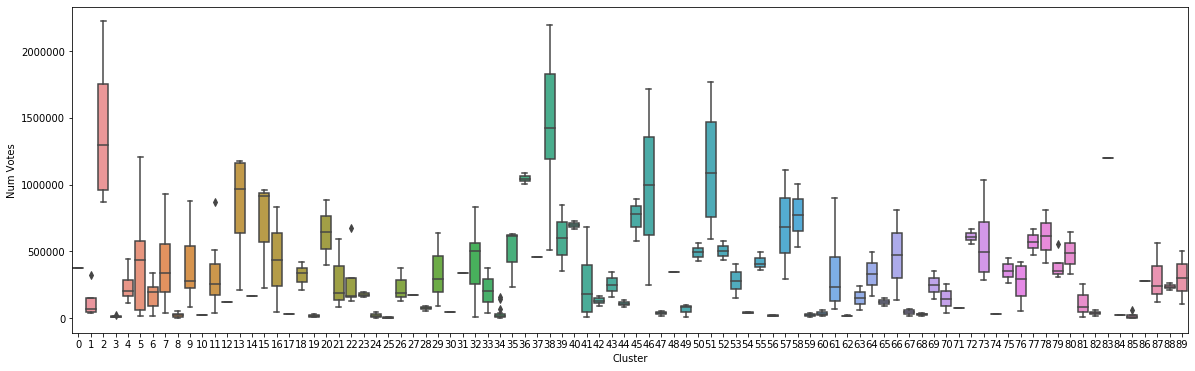

In [237]:
plt.figure(figsize=(20,6))
sns.boxplot(x = 'Cluster', y = 'Num Votes', data = data_film_orig)